In [35]:
# from pymodelica import compile_fmu
import traceback
import logging
import typing as t

from pyfmi import load_fmu
# import pymodelica

import os
import shutil
import sys
import matplotlib.pyplot as plt

from pathlib import Path

import pandas as pd
import numpy as np
import altair as alt

from importlib import reload

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

<ipython-input-112-da8cdcdc9466>:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  model.set(var, res.final(var))


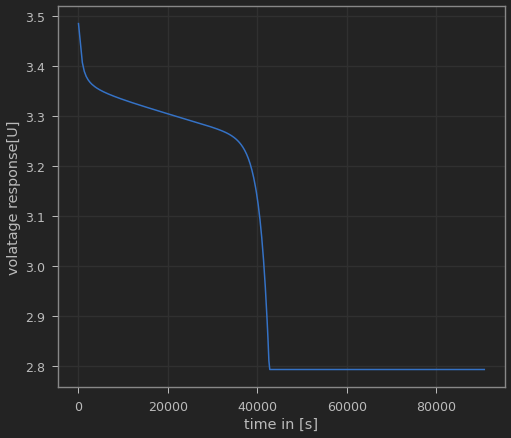

In [112]:
from pyfmi import load_fmu

def full_var_name(name):
    translator = {'time': 'time',
                  'U_ocv': 'theveninBasedBattery.voltageSource.U_ocv.v',
                  'R_ts': 'theveninBasedBattery.R_ts.v',
                  'R_tl': 'theveninBasedBattery.R_tl.v',
                  'I_int': 'theveninBasedBattery.coulombSocCounter.integrator.y',
                  'SoC_int': 'theveninBasedBattery.capacityFadingCalc.socIntegrator.y',
                  'SoC_square_int': 'theveninBasedBattery.capacityFadingCalc.socSquareIntegrator.y',
                  'xi': 'theveninBasedBattery.capacityFadingCalc.capacityFade',
                  'Ah_throughput': 'theveninBasedBattery.capacityFadingCalc.Ah_throughput.y',
                  't_last': 'theveninBasedBattery.capacityFadingCalc.cycleStartTime',
                  'I_req': 'I_req',
                  'SoC': 'theveninBasedBattery.coulombSocCounter.SoC', 
                  'SoH': 'theveninBasedBattery.SoH', 
                  }
    return translator[name]

model = load_fmu('./BatteryMPC_BatteryWithFullCycle.fmu', log_level=4)

C_bat = 1.1
c_rate_per_second = C_bat/3600

start_time = 0
final_time = 24*60*60
control_df = pd.DataFrame({"Time": range(start_time, final_time)})
control_df['I_bat'] = - c_rate_per_second/12
control_df.loc[control_df['Time'] < (
    final_time - start_time)/2, 'I_bat'] = c_rate_per_second/12
control_df.set_index('Time', inplace=True)

model.reset()
model.initialize(start_time=0, stop_time=final_time//8)
opts = model.simulate_options()
opts['ncp'] = 50
opts['initialize'] = False
opts['silent_mode'] = True
res = model.simulate(start_time, final_time//8, input=('I_req', control_df.reset_index().values[start_time:final_time//4]), options=opts)

state_vars = list(filter(lambda x: res.is_variable(x), res.keys()))
states = pd.DataFrame(data=np.array([res[i] for i in state_vars]).T,
                      columns=state_vars)
for i in np.arange(final_time//8, final_time, 10000):
    for j in range(4):
        model.reset()
        model.initialize(start_time=i, stop_time=i+10000)
    #     model.setup_experiment(final_time//4, stop_time=final_time)
    #     model.initialize()
        for var in state_vars:
            if var == 'time':
                continue
            model.set(var, res.final(var))

        opts = model.simulate_options()
        opts['ncp'] = 50
        opts['initialize'] = False
        opts['silent_mode'] = True

        res2 = model.simulate(i, i+10000, ('I_req', control_df.reset_index().values[start_time:final_time//4]), options=opts)
    res = res2

    states2 = pd.DataFrame(data=np.array([res[i] for i in state_vars]).T,
                          columns=state_vars)
    states = states.append(states2)
    
plt.plot(states['time'], states[full_var_name('U_ocv')])
plt.xlabel('time in [s]')
plt.ylabel('volatage response[U]')
plt.grid()
plt.show()

In [149]:
# build modelica fmu
!PYTHONPATH=/usr/local/JModelica/Python/:/usr/local/JModelica/Python/pymodelica/: python2 build_fmu.py

Warning at line 7, column 9, in file '/home/developer/modelica/BatteryWithFullCycle.mo':
  Iteration variable "theveninBasedBattery.voltageSource.signalVoltage.signalSource.height" is missing start value!
/usr/local/JModelica/lib/RuntimeLibrary/libModelicaMatIO.a(ModelicaMatIO.c.o): In function `Mat_VarDelete':
/usr/local/src/JModelica/ThirdParty/MSL/Modelica/Resources/C-Sources/ModelicaMatIO.c:8521: warning: the use of `mktemp' is dangerous, better use `mkstemp' or `mkdtemp'



 20%|██        | 1/5 [00:00<00:02,  1.41it/s]

1.0


 40%|████      | 2/5 [00:01<00:01,  1.59it/s]

1.0


 60%|██████    | 3/5 [00:01<00:01,  1.67it/s]

1.0


 80%|████████  | 4/5 [00:02<00:00,  1.70it/s]

1.0


100%|██████████| 5/5 [00:03<00:00,  1.67it/s]

1.0


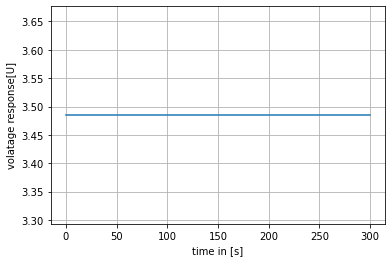

In [75]:
    # mpc_optimizer.optimize(0, 100,)
import mpc_optimizer
reload(mpc_optimizer)

from mpc_optimizer import MPCOptimizer, FmuSource

state_vars = [
    'time',
    'theveninBasedBattery.voltageSource.U_ocv.v', 'theveninBasedBattery.R_ts.v',
    'theveninBasedBattery.R_tl.v',
    'theveninBasedBattery.coulombSocCounter.integrator.y',
    'theveninBasedBattery.capacityFadingCalc.socIntegrator.y',
    'theveninBasedBattery.capacityFadingCalc.socSquareIntegrator.y',
    'theveninBasedBattery.capacityFadingCalc.capacityFade',
    'theveninBasedBattery.capacityFadingCalc.Ah_throughput.y',
    'theveninBasedBattery.capacityFadingCalc.cycleStartTime',
    'I_req'
]


def full_var_name(name):
    translator = {'time': 'time',
                  'U_ocv': 'theveninBasedBattery.voltageSource.U_ocv.v',
                  'R_ts': 'theveninBasedBattery.R_ts.v',
                  'R_tl': 'theveninBasedBattery.R_tl.v',
                  'I_int': 'theveninBasedBattery.coulombSocCounter.integrator.y',
                  'SoC_int': 'theveninBasedBattery.capacityFadingCalc.socIntegrator.y',
                  'SoC_square_int': 'theveninBasedBattery.capacityFadingCalc.socSquareIntegrator.y',
                  'xi': 'theveninBasedBattery.capacityFadingCalc.capacityFade',
                  'Ah_throughput': 'theveninBasedBattery.capacityFadingCalc.Ah_throughput.y',
                  't_last': 'theveninBasedBattery.capacityFadingCalc.cycleStartTime',
                  'I_req': 'I_req',
                  'SoC': 'theveninBasedBattery.coulombSocCounter.SoC', 
                  'SoH': 'theveninBasedBattery.SoH', 
                  }
    return translator[name]


mpc_optimizer = MPCOptimizer(
    fmu=FmuSource.from_fmu(Path('./BatteryMPC_BatteryWithFullCycle.fmu')),
    state_variables=state_vars,
    input_vec=['I_req'],
    output_vec=['theveninBasedBattery.coulombSocCounter.SoC', 'theveninBasedBattery.SoH'],
    horizon_num=5,
    mpc_step=60
)

C_bat = 1.1
c_rate_per_second = C_bat/3600

start_time = 0
final_time = 24*60*60
control_df = pd.DataFrame({"Time": range(start_time, final_time)})
control_df['I_bat'] = - c_rate_per_second/12
control_df.loc[control_df['Time'] < (
    final_time - start_time)/2, 'I_bat'] = c_rate_per_second/12
control_df.set_index('Time', inplace=True)


def cost_func(state: t.Dict[str, t.Any], input: t.Dict[str, t.Any], output: t.Dict[str, t.Any]) -> float:
    return -output[full_var_name('SoC')]


new_control_df = mpc_optimizer.optimize(
    0, 300, control_df, objective_func=cost_func)
states = mpc_optimizer.simulate(0, 300, new_control_df, save_all=True)
# states = mpc_optimizer.simulate(0, 30, control_df, save_all=True)

plt.plot(states['time'], states[full_var_name('U_ocv')])
# plt.plot(states['time'], states['I_req'])
plt.xlabel('time in [s]')
plt.ylabel('volatage response[U]')
plt.grid()
plt.show()

## Test cycle simulation

In [233]:
import mpc_optimizer
reload(mpc_optimizer)

from mpc_optimizer import MPCOptimizer, FmuSource

state_vars = [
    'time',
    'theveninBasedBattery.voltageSource.U_ocv.v', 'theveninBasedBattery.R_ts.v',
    'theveninBasedBattery.R_tl.v',
    'theveninBasedBattery.coulombSocCounter.integrator.y',
    'theveninBasedBattery.capacityFadingCalc.socIntegrator.y',
    'theveninBasedBattery.capacityFadingCalc.socSquareIntegrator.y',
    'theveninBasedBattery.capacityFadingCalc.capacityFade',
    'theveninBasedBattery.capacityFadingCalc.Ah_throughput.y',
    'theveninBasedBattery.capacityFadingCalc.cycleStartTime',
#     'I_req',
    'theveninBasedBattery.v'
]

full_var_name = {
              'time': 'time',
              'U_ocv': 'theveninBasedBattery.voltageSource.U_ocv.v',
              'R_ts': 'theveninBasedBattery.R_ts.v',
              'R_tl': 'theveninBasedBattery.R_tl.v',
              'I_int': 'theveninBasedBattery.coulombSocCounter.integrator.y',
              'SoC_int': 'theveninBasedBattery.capacityFadingCalc.socIntegrator.y',
              'SoC_square_int': 'theveninBasedBattery.capacityFadingCalc.socSquareIntegrator.y',
              'xi': 'theveninBasedBattery.capacityFadingCalc.capacityFade',
              'Ah_throughput': 'theveninBasedBattery.capacityFadingCalc.Ah_throughput.y',
              't_last': 'theveninBasedBattery.capacityFadingCalc.cycleStartTime',
              'I_req': 'I_req',
              'SoC': 'theveninBasedBattery.coulombSocCounter.SoC', 
              'SoH': 'theveninBasedBattery.SoH',
              'U' : 'theveninBasedBattery.v'
              }
mpc = MPCOptimizer(
    fmu=FmuSource.from_fmu(Path('/home/developer/ipynotebooks/BatteryMPC_BatteryWithFullCycle.fmu')),
    state_variables=state_vars,
    input_vec=['I_req'],
    output_vec=['theveninBasedBattery.coulombSocCounter.SoC', 'theveninBasedBattery.SoH'],
    horizon_num=5,
    mpc_step=60
)

C_bat = 1.1
c_rate_per_second = C_bat/3600

test_df = pd.read_csv('plots_data/test_cycle.csv')
test_df = test_df.rename(columns={'x': 'Time'})
test_df['y'] = test_df['y']*c_rate_per_second
test_df['Time'] = test_df['Time'].apply(lambda x: max(x, 0))
test_df['Time'] = pd.to_datetime(test_df['Time'], unit='m')
test_df = test_df.set_index('Time').resample("s").mean().interpolate(
    method='time', axis=0)

test_df['Time'] = test_df.reset_index()['Time'].values.astype('int')/10**9
test_df = test_df.set_index('Time')


start_time = 0
final_time = len(test_df)

states = mpc.simulate(start_time, final_time, test_df, save_all=True)
states[full_var_name['U']] *= -1

alt.Chart(states.rename(columns={v: k for k, v in full_var_name.items()})).mark_line(interpolate='step').encode(
    x = alt.X('time:Q', title='time'),
    y = alt.Y("U:Q", scale=alt.Scale(zero=False)),
#     color=alt.value('red')
#     color=alt.Color('type:N', scale=alt.Scale(scheme='set1'))
).configure_view(
    height=300, 
    width=800
).configure_legend(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=15,
    titleFontSize=15,
).configure_axis(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=15,
    titleFontSize=15,
)

alt.Chart(...)

## MPCPy optimization

### Run Emulation from Modelica file

In [ ]:
from mpcpy import variables, units, exodata
from mpcpy import systems, models, optimization

import pandas as pd
import numpy as np
import altair as alt

from collections import defaultdict 

alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()

In [ ]:
soc_setpoint = variables.Static('SoC_setpoint', 1, units.unit1)
soh_setpoint = variables.Static('SoH_setpoint', 1, units.unit1)

In [ ]:
C_bat = 1.1
c_rate_per_second = C_bat/3600

variable_map = {'I_bat': ('I_req', units.unit1) }
control_df = pd.DataFrame({"Time": pd.date_range("1/1/2017", "1/2/2017", freq='s')})
control_df['I_bat'] = - c_rate_per_second/12
control_df.loc[control_df['Time'] < pd.to_datetime("1/1/2017 12:00:00"), 'I_bat'] = c_rate_per_second/12
control_df.set_index('Time', inplace=True)
control = exodata.ControlFromDF(control_df, variable_map)
control.collect_data('1/1/2017', '1/3/2017')

In [ ]:
moinfo = ('/home/developer/modelica/BatteryWithFullCycle.mo',
          'BatteryMPC.BatteryWithFullCycle', {})

measurements = defaultdict(dict)
sample_rate = 1

measurements['theveninBasedBattery.voltageSource.U_ocv.v']['Sample'] = variables.Static(
    'sample_rate_theveninBasedBattery.voltageSource.U_ocv.v', sample_rate, units.s)

measurements['theveninBasedBattery.coulombSocCounter.SoC']['Sample'] = variables.Static(
    'sample_rate_theveninBasedBattery.coulombSocCounter.SoC', sample_rate, units.s)

measurements['theveninBasedBattery.SoH']['Sample'] = variables.Static(
    'sample_rate_theveninBasedBattery.SoH', sample_rate, units.s)

measurements['theveninBasedBattery.I_bat.i']['Sample'] = variables.Static(
    'sample_rate_theveninBasedBattery.I_bat.i', sample_rate, units.s)

In [ ]:
emulation = systems.EmulationFromFMU(measurements, 
                                     moinfo=moinfo,
                                     control_data=control.data
                                    )

In [ ]:
emulation.collect_measurements('1/1/2017', '1/2/2017')

In [ ]:
df = emulation.display_measurements('Measured').reset_index().rename(columns={
    'theveninBasedBattery.voltageSource.U_ocv.v': 'U_ocv', 'theveninBasedBattery.SoH': 'SoH', 
    'theveninBasedBattery.coulombSocCounter.SoC': 'SoC',
    'theveninBasedBattery.I_bat.i': 'I_bat'
})
alt.Chart(df).mark_line(interpolate='step').encode(
    x=alt.X('Time:T', title='time'),
#     y=alt.Y('I_bat:Q', scale=alt.Scale(zero=False), title='I, [A]'),
#     y=alt.Y('U_ocv:Q', scale=alt.Scale(zero=False), title='U, [V]'),
#     y= alt.Y('SoH:Q'),
    y= alt.Y('SoC:Q'),
    #     color=alt.value('red')
).configure_view(
    height=300,
    width=800
).configure_legend(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=15,
    titleFontSize=15,
).configure_axis(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=15,
    titleFontSize=15,
)

### Run simulation from Modelica (parameters can be estimated)

In [ ]:
parameters = exodata.ParameterFromDF(pd.DataFrame(columns=["Name", "Free", "Value", "Minimum", "Maximum", "Covariance", "Unit"]).set_index('Name'))
parameters.collect_data()
parameters.display_data()

In [ ]:
import imp
imp.reload(models)
imp.reload(optimization)
imp.reload(systems)

In [ ]:
model = models.Modelica(models.JModelicaParameter,
                        models.RMSE,
                        emulation.measurements,
                        moinfo = moinfo,
                        parameter_data = parameters.data,
                        control_data = control.data
                       )

In [ ]:
model.simulate('1/1/2017', '1/2/2017')

In [ ]:
df = model.display_measurements('Simulated').reset_index().rename(columns={
    'theveninBasedBattery.voltageSource.U_ocv.v': 'U_ocv', 'theveninBasedBattery.SoH': 'SoH', 
    'theveninBasedBattery.coulombSocCounter.SoC': 'SoC',
    'theveninBasedBattery.I_bat.i': 'I_bat'
})
alt.Chart(df).mark_line(interpolate='step').encode(
    x=alt.X('Time:T', title='time'),
#     y=alt.Y('I_bat:Q', scale=alt.Scale(zero=False), title='I, [A]'),
#     y=alt.Y('U_ocv:Q', scale=alt.Scale(zero=False), title='U, [V]'),
#     y= alt.Y('SoH:Q'),
    y= alt.Y('SoC:Q'),
    #     color=alt.value('red')
).configure_view(
    height=300,
    width=800
).configure_legend(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=15,
    titleFontSize=15,
).configure_axis(
    labelFont='CMU Serif',
    titleFont='CMU Serif',
    labelFontSize=15,
    titleFontSize=15,
)

### Run optimization for battery charging

In [ ]:
from mpcpy import optimization

In [ ]:
variable_map = { 
    "SoC_min": ('theveninBasedBattery.coulombSocCounter.SoC', 'GTE', units.unit1),
    "SoC_max": ('theveninBasedBattery.coulombSocCounter.SoC', 'LTE', units.unit1),
    "SoH_min": ('theveninBasedBattery.SoH', 'GTE', units.unit1),
    "SoH_max": ('theveninBasedBattery.SoH', 'LTE', units.unit1),
    "I_bat_min": ('theveninBasedBattery.I_bat.i', 'GTE', units.unit1),
    "I_bat_max": ('theveninBasedBattery.I_bat.i', 'LTE', units.unit1),
               }

In [ ]:
constraints_df = pd.DataFrame({"Time": pd.date_range("1/1/2017", "1/2/2017", freq='s')})
constraints_df['SoC_min'] = 0
constraints_df['SoC_max'] = 1
constraints_df['SoH_min'] = 0
constraints_df['SoH_max'] = 1
constraints_df['I_bat_min'] = -0.05
constraints_df['I_bat_max'] = 0.05
constraints_df.set_index('Time', inplace=True)

In [ ]:
constraints = exodata.ConstraintFromDF(constraints_df, variable_map=variable_map)

In [ ]:
constraints.collect_data('1/1/2017', '1/2/2017')

In [ ]:
opt_problem = optimization.Optimization(model,
                                        optimization.EnergyMin,
                                        optimization.JModelica,
                                        'theveninBasedBattery.SoH',
#                                         constraint_data = constraints.data
                                       )